<h1><center>Exercise 7 7</center></h1>
<h2><center>Image analysis using watershed</center></h2>

In [1]:
#importamos librerías necesarias
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math


Leer y representar manzanas

<IPython.core.display.Javascript object>


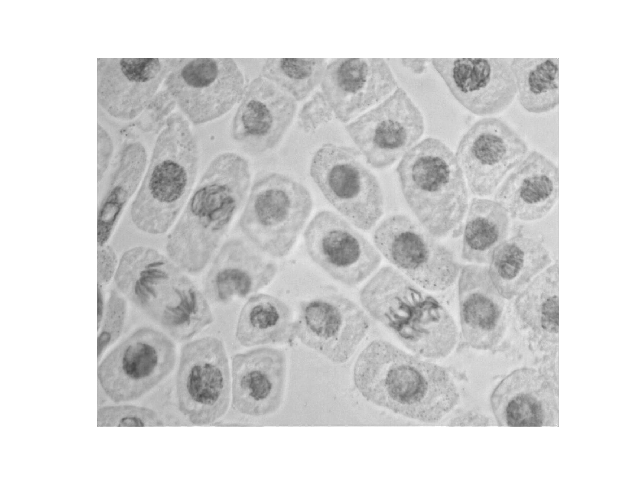

In [2]:
%matplotlib notebook
I = cv2.imread('cells.jpg', 0)
Icolor = cv2.imread('cells.jpg', 1)

plt.figure(1)
plt.imshow(I, cmap='gray')
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()

<IPython.core.display.Javascript object>


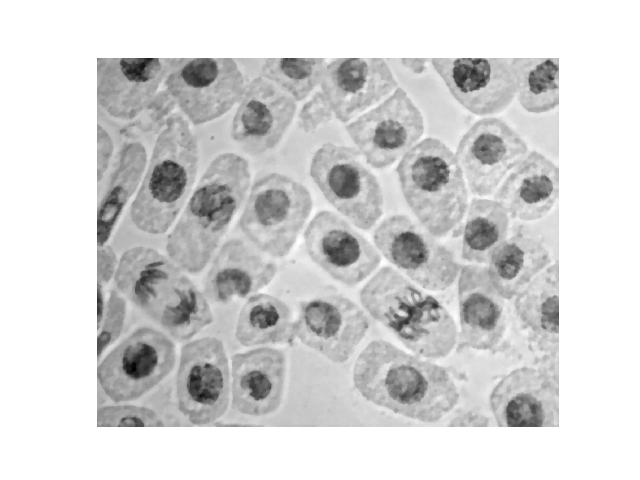

In [3]:
EE1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
EE2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
EE3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))


open1 = cv2.morphologyEx(I, cv2.MORPH_OPEN, EE1)
clos1 = cv2.morphologyEx(open1, cv2.MORPH_CLOSE, EE1)
open2 = cv2.morphologyEx(clos1, cv2.MORPH_OPEN, EE2)
clos2 = cv2.morphologyEx(open2, cv2.MORPH_CLOSE, EE2)
open3 = cv2.morphologyEx(clos2, cv2.MORPH_OPEN, EE3)
I_ASF3 = cv2.morphologyEx(open3, cv2.MORPH_CLOSE, EE3)

plt.figure(2)
plt.imshow(I_ASF3, cmap='gray')
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()

In [4]:
print(I_ASF3[268,213])

183


<IPython.core.display.Javascript object>


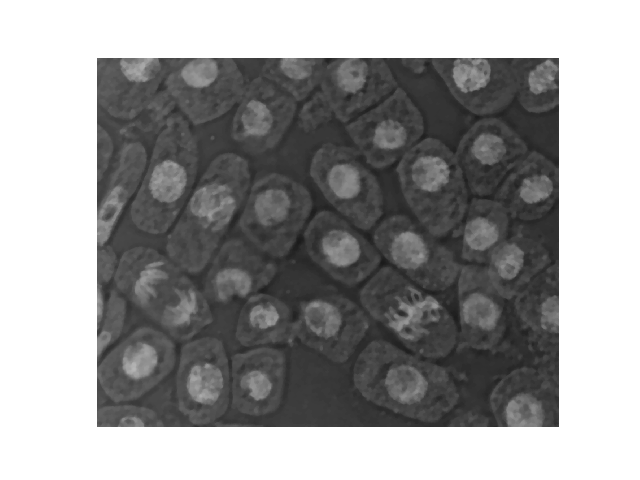

In [5]:
I_neg = 255 - I_ASF3

plt.figure('neg')
plt.imshow(I_neg, cmap='gray', vmin = 0, vmax = 255)
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()

[[93 91 91 ... 63 63 63]
 [93 91 90 ... 62 62 63]
 [90 90 90 ... 62 62 62]
 ...
 [80 80 80 ... 49 49 49]
 [80 80 80 ... 49 49 49]
 [84 80 80 ... 49 49 49]]


<IPython.core.display.Javascript object>


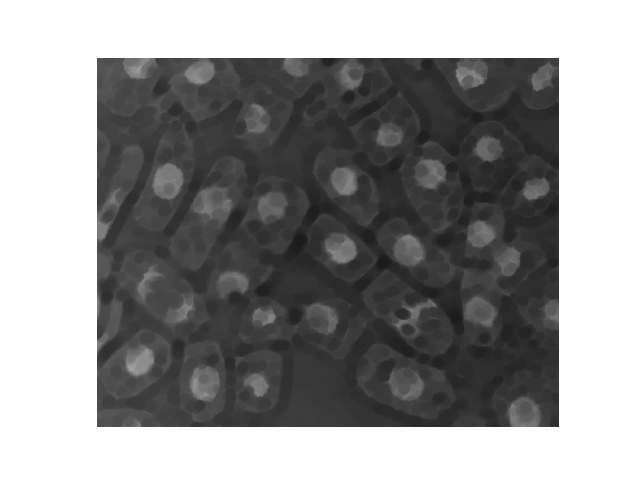

<IPython.core.display.Javascript object>


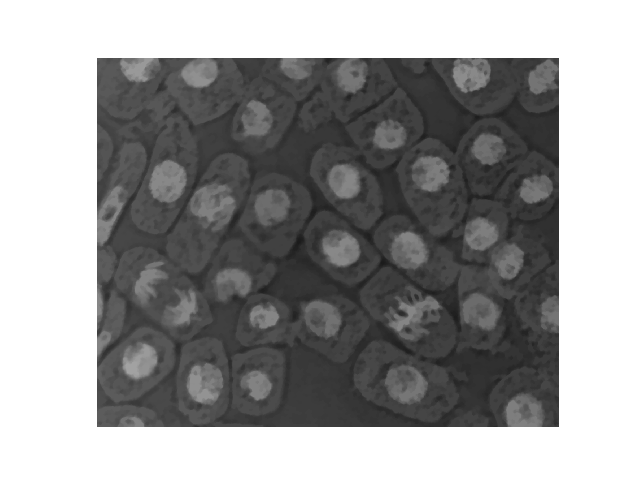

In [6]:
from imreconstruct import imreconstruct

EEnuevo = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (19,19))

I_marker = cv2.erode(I_neg,EEnuevo,iterations = 1)
I_rec = imreconstruct(I_marker, I_neg)

plt.figure('erosion')
plt.imshow(I_marker, cmap='gray', vmin = 0, vmax = 255)
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()

plt.figure('reconstruction')
plt.imshow(I_rec, cmap='gray', vmin = 0, vmax = 255)
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()

<IPython.core.display.Javascript object>


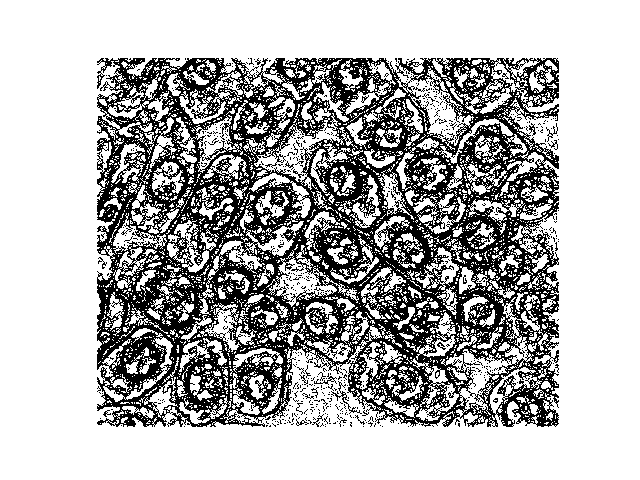

In [24]:
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

conn = np.ones((3,3))
coordinates = peak_local_max(I_rec, footprint=conn, indices=False, exclude_border=0)
lm2 = np.uint8(coordinates)
plt.figure('local max 1')
plt.imshow(lm2, cmap='gray', vmin = 0, vmax = 1)
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()



<IPython.core.display.Javascript object>


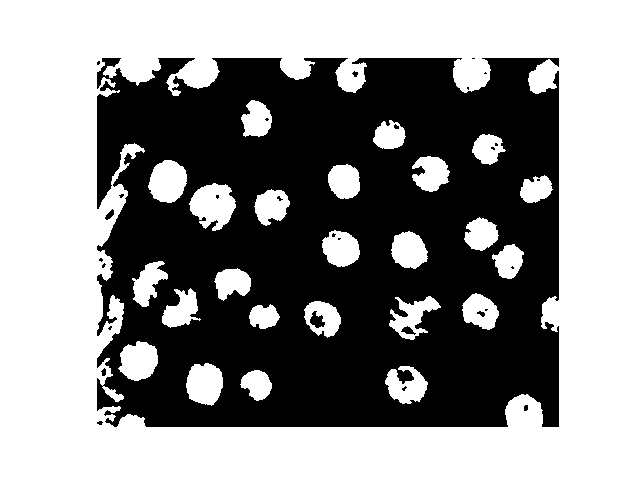

In [20]:
[thresh, th2] = cv2.threshold(I_rec, 88, 255, cv2.THRESH_BINARY)

plt.figure('threshold')
plt.imshow(th2, cmap='gray', vmin = 0, vmax = 255)
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()

<IPython.core.display.Javascript object>


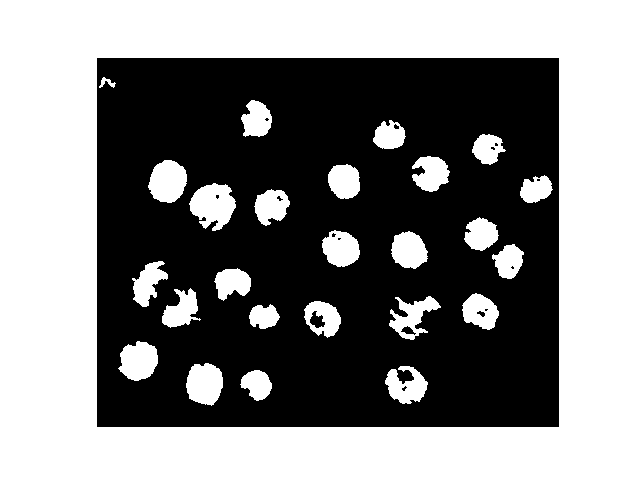

In [21]:
from clearborder import imclearborder

Iclear = imclearborder(th2, 5)


plt.figure('clearborders')
plt.imshow(Iclear, cmap='gray', vmin = 0, vmax = 255)
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()

int32


<IPython.core.display.Javascript object>


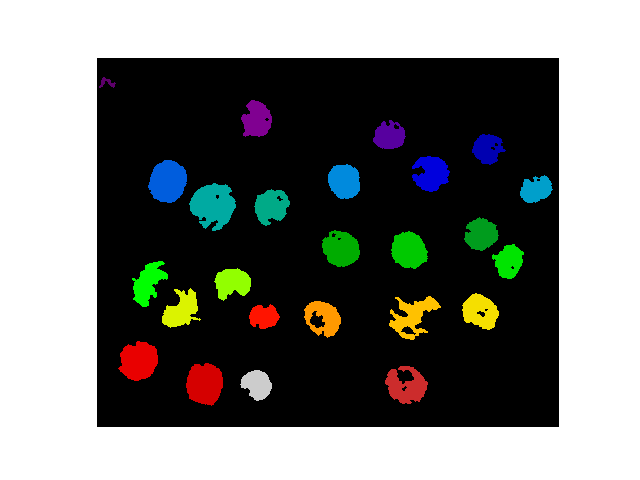

In [23]:
ret, markers = cv2.connectedComponents(Iclear)
print(markers.dtype)

plt.figure('Segmented image')
plt.imshow(markers, cmap=plt.cm.get_cmap('nipy_spectral'))
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()

<IPython.core.display.Javascript object>


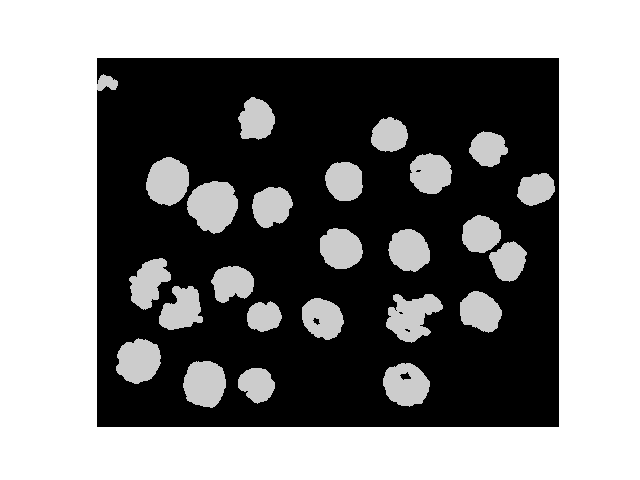

<IPython.core.display.Javascript object>


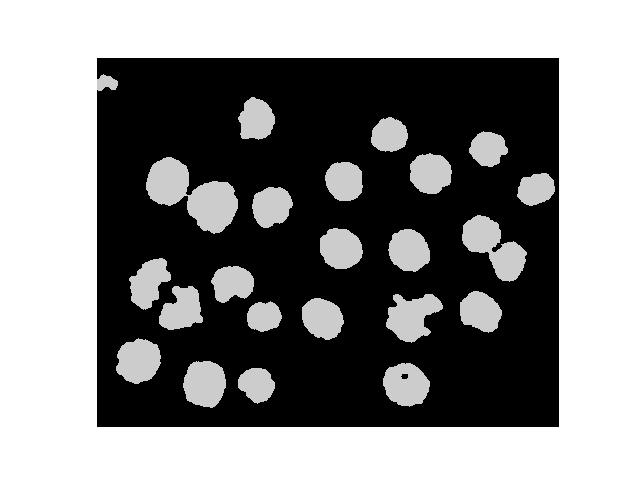

In [35]:
EE4 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))

I_dilate =cv2.dilate(Iclear, EE4)
close = cv2.morphologyEx(I_dilate, cv2.MORPH_CLOSE, EE4)

plt.figure('dilate')
plt.imshow(I_dilate, cmap=plt.cm.get_cmap('nipy_spectral'))
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()

plt.figure('close')
plt.imshow(close, cmap=plt.cm.get_cmap('nipy_spectral'))
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()

<IPython.core.display.Javascript object>


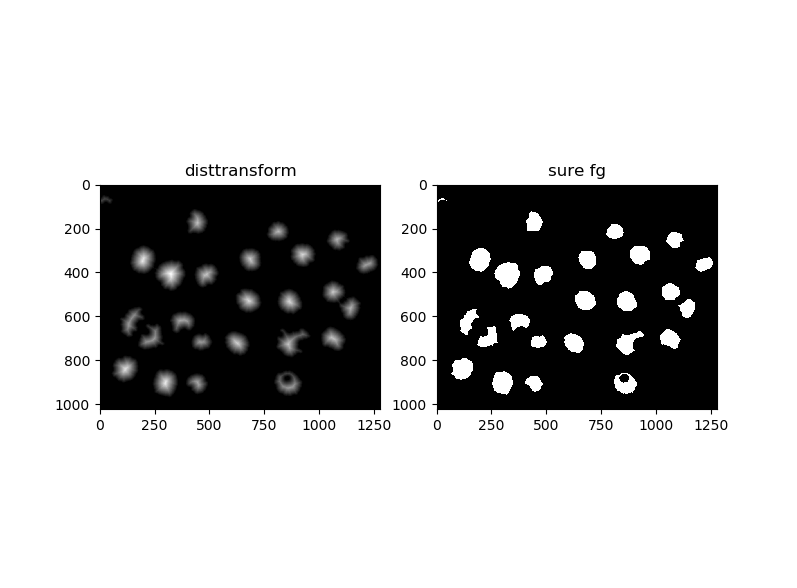

In [36]:
dist_transform = cv2.distanceTransform(close,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.2*dist_transform.max(),255,0)

plt.figure('disttrnsform')
plt.subplot(1,2,1)
plt.title('disttransform')
plt.imshow(dist_transform, cmap = 'gray')

plt.subplot(1,2,2)
plt.title('sure fg')
plt.imshow(sure_fg, cmap = 'gray')

plt.show()


<IPython.core.display.Javascript object>


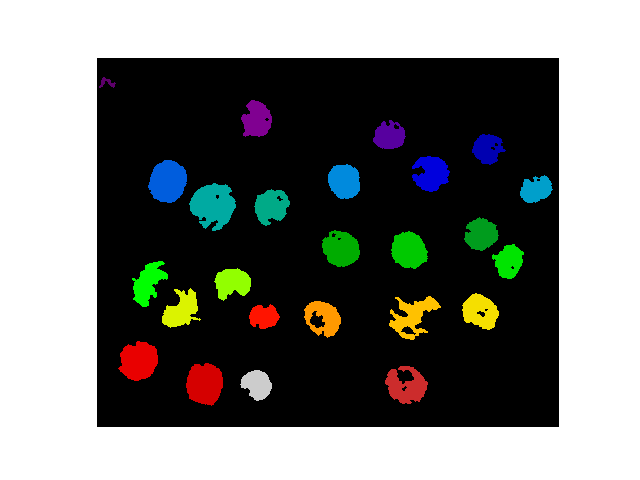

In [37]:
ret, segmented = cv2.connectedComponents(np.uint8(sure_fg))

plt.figure('components')
plt.imshow(markers, cmap=plt.cm.get_cmap('nipy_spectral'))
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()


<IPython.core.display.Javascript object>


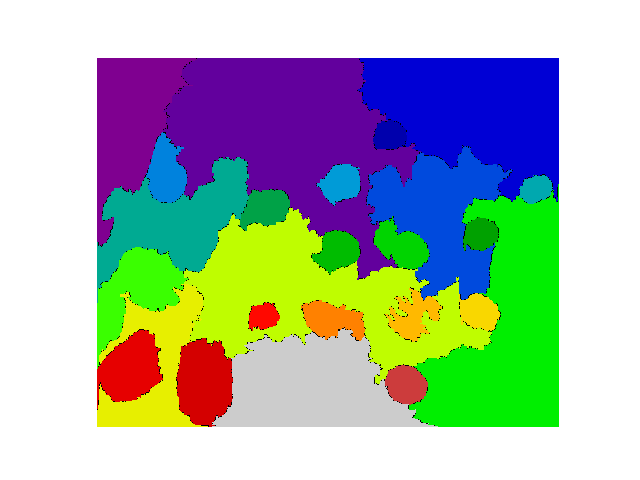

In [38]:
markers2 = cv2.watershed(Icolor,markers)

plt.figure('watershed')
plt.imshow(markers2, cmap=plt.cm.get_cmap('nipy_spectral'))
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()

int32


<IPython.core.display.Javascript object>


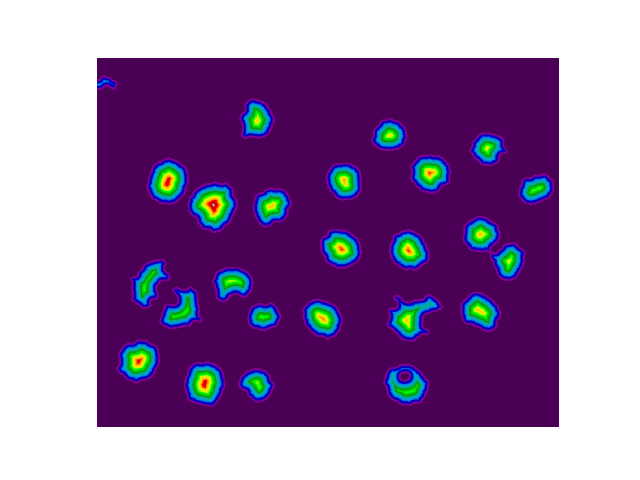

In [39]:
dist_transform = dist_transform.astype('int32')
print(dist_transform.dtype)
markers3 = cv2.watershed(Icolor,dist_transform)


plt.figure('sin binaria después de disttransform')
plt.imshow(markers3, cmap=plt.cm.get_cmap('nipy_spectral'))
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()